In [1]:
naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_transbench101_micro'

In [2]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores


search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [47]:
dataset = 'segmentsemantic'
proxy = 'nwot'
data = dfs[dataset]

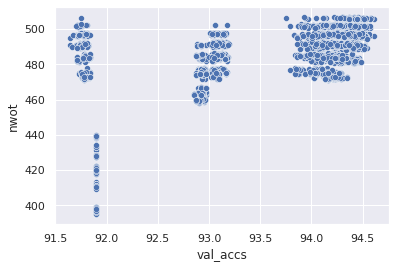

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.scatterplot(data=data, x='val_accs', y=proxy)
#plt.xlim(70, 91)
#plt.ylim(-1, 300)
#plt_ylim(proxy)
plt.show()

In [49]:
from zc_combine.operations import parse_ops_nb201, count_all_ops

count_set = {0, 1, 2, 3}
ops = parse_ops_nb201(data)
count_all_ops(data, ops, count_set)

In [50]:
# TNB101_micro op names and edge indices to edges for convenience
# Op indices for zero and identity are 0, 1, in NB201 they are 1, 0
OP_NAMES = ["Zero", "Identity", "ReLUConvBN3x3", "ReLUConvBN1x1", "AvgPool1x1"]
OP_NAMES_NB201 = ['none', 'skip_connect', 'nor_conv_3x3', 'nor_conv_1x1', 'avg_pool_3x3']

EDGE_LIST = ((1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4))

## NASWOT bias
NASWOT seems to be highly biased towards the number of convolutions. Let us define `count` == number of `Conv3x3` + number of `Conv1x1` in a cell.

Then, plotting every count (from 1 to 6) as a different colour, we get this:

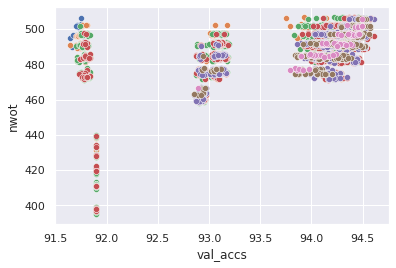

In [51]:
from zc_combine.operations import plot_clouds

plot_clouds(data, (1, 3), proxy, vmin=0, vmax=7)
#plt.ylim(-32.8, -31.8)
#plt_ylim(proxy)
plt.show()

In [8]:
data[data['val_accs'] > 39]

,net,val_accs,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,zen,epe_nas,synflow,random,rank,"(2,)","(3,)","(2, 3)"
0,"(2, 3, 2, 3, 2, 3)",42.759754,4.458780,4662.880768,74.508804,-2.955261,-32.010446,1265.389038,500.717764,22.391940,0.066559,656.970154,140.918808,451.375314,108.596648,1196,1432.0,3,3,6
1,"(3, 1, 1, 2, 1, 2)",42.316879,0.685677,1719.888384,20.240038,-0.260801,-32.011969,730.687561,482.160494,7.911300,0.054861,179.962784,80.168358,838.104942,80.325202,2254,1945.0,2,1,3
3,"(3, 3, 3, 3, 0, 0)",42.411427,0.249479,5463.075328,6.833540,0.003300,-32.012307,828.335632,488.500280,26.117252,0.008881,57.221085,103.818619,823.921237,49.518576,3231,1861.0,0,4,4
4,"(2, 1, 0, 1, 3, 0)",42.804539,0.659891,1801.906688,15.660104,-0.071710,-32.032110,632.680176,472.649484,8.776324,0.042213,143.749313,62.030872,612.023126,78.312719,4089,1374.0,1,1,2
5,"(1, 0, 2, 0, 3, 1)",42.078026,0.533644,1800.759808,13.582209,-0.051730,-32.013104,552.923523,467.783782,8.774532,0.022371,127.051926,57.417717,481.159374,62.372724,2657,2143.5,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,"(3, 3, 3, 1, 0, 2)",44.153065,0.909518,4373.244416,30.881533,-0.187820,-32.012418,948.201050,489.694640,21.023620,0.055849,299.446136,113.669861,572.671152,117.801916,706,124.0,1,3,4
4091,"(1, 3, 1, 2, 0, 3)",42.819466,0.611565,3062.065664,21.564592,-0.168459,-32.011389,730.529236,482.606920,14.727044,-0.008370,193.672592,85.900841,741.089293,90.366001,1572,1353.5,1,2,3
4092,"(2, 2, 2, 0, 3, 3)",39.450638,6.198863,3577.965056,86.561401,-2.336487,-32.019332,1067.456665,493.603007,17.643652,0.045739,687.399597,109.258804,452.517163,107.955520,1633,2851.5,3,2,5
4094,"(3, 0, 1, 0, 2, 2)",41.197254,4.259406,1718.741504,43.316685,-1.310471,-32.011036,650.607178,478.166322,7.909508,0.018722,332.975159,65.601761,735.741729,85.261094,3021,2632.5,2,1,3


Let us zoom on a cloud, let's say `count` == 4 (red if plotting from `count` == 1).

Then, the clouds don't seem to depend on the number of `Conv3x3`.

But, accuracy seems to depend on it a bit!

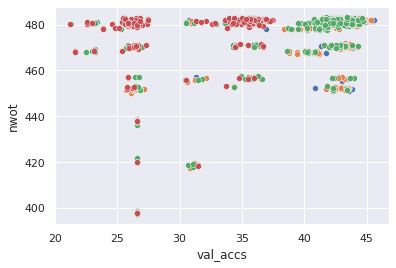

In [23]:
zoom = 3

data_zoom = data[data[str((2, 3))] == zoom]
plot_clouds(data_zoom, data_zoom[str((2,))], proxy, vmax=7)
#plt.xlim(69, 93)
#plt.ylim(700, 820)
plt.show()

Similar to NAS-Bench-201, there is some regularity in different score values:
- nets in the lowest cluster have inactive edges (1,2) and (1,3)
- nets in the second lowest cluster have inactive edge (1,2)
- nets in the second highest cluster have either inactive edge (1,2) and no other inactive, or have inactive both (1,3) and (1,4)
- nets in the highest cluster never have the highest edge inactive

In [42]:
import numpy as np
from zc_combine.operations import filter_by_range

def get_op_array(df):
    ops = parse_ops_nb201(df)
    return np.array(ops)

ops_0 = get_op_array(filter_by_range(data_zoom, proxy, 450, 465))
ops_1 = get_op_array(filter_by_range(data_zoom, proxy, 465, 475))
ops_2 = get_op_array(filter_by_range(data_zoom, proxy, 475, 483))
ops_3 = get_op_array(filter_by_range(data_zoom, proxy, 483, 500))

In [44]:
np.unique(ops_0[:, 0]), np.unique(ops_0[:, 1])

(array([0]), array([0]))

In [26]:
np.unique(ops_1[:, 0]), np.unique(ops_1[:, 1])

(array([0]), array([1, 2, 3]))

In [35]:
ops_2[ops_2[:, 0] != 0]

array([[3, 0, 0, 2, 3, 2],
       [2, 0, 0, 3, 2, 2],
       [3, 0, 0, 3, 3, 2],
       [3, 0, 0, 2, 3, 3],
       [2, 0, 0, 3, 3, 2],
       [2, 0, 0, 2, 2, 3],
       [2, 0, 0, 3, 2, 3],
       [3, 0, 0, 2, 2, 2],
       [2, 0, 0, 2, 2, 2],
       [2, 0, 0, 2, 3, 3],
       [3, 0, 0, 3, 3, 3],
       [2, 0, 0, 3, 3, 3],
       [2, 0, 0, 2, 3, 2],
       [3, 0, 0, 3, 2, 2],
       [3, 0, 0, 2, 2, 3],
       [3, 0, 0, 3, 2, 3]])

In [27]:
np.unique(ops_2[:, 0]), np.unique(ops_2[:, 1])

(array([0, 2, 3]), array([0, 2, 3]))

In [28]:
np.unique(ops_3[:, 0]), np.unique(ops_3[:, 1])

(array([1, 2, 3]), array([0, 1, 2, 3]))

## Conclusion
NASWOT score has problems on other datasets than CIFAR-10 as well.